<a href="https://colab.research.google.com/github/Harm1995/CTA-sensitivity/blob/master/Creating_the_count_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  import gammapy
  import iminuit
  from iminuit import Minuit

except:

  !pip install gammapy
  !pip install iminuit

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
from astropy.io import fits
from astropy import units as u
import gammapy
from gammapy.irf import Background3D
import pandas as pd 
import random
import scipy
from scipy.stats import norm
import seaborn as sns
import time

sns.set()


In [0]:
roi = 5
TeV = 10**-6
energy_start_bin = 3
offset = 1
pre_normalisation = 10**-20
time = 500 * 3600

In [0]:
pre_path = "/content/drive/My Drive/Colab Notebooks/master_project/"
ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"


### Here we get the diffusive emission maps:
ics_ring_maps = []
GCE_ring_maps = []
for i in range(1,5):
  ics = np.roll(fits.getdata(ring_path + 'ics_ring_'+str(i) +'.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  brems = np.roll(fits.getdata(ring_path + 'bremss_ring_'+ str(i) +'.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  pion = np.roll(fits.getdata(ring_path + 'pion_ring_1'+ str(i) +'.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  ics_ring_maps.append(ics)
  GCE_ring_maps.append(brems + pion)

GDE_maps = []
GDE_maps.append(ics_ring_maps)
GDE_maps.append(GCE_ring_maps)
GDE_maps = np.array(GDE_maps)

### We als need the fermi map and the signal map:
fermi_map = fits.getdata(pre_path + 'fig12_bubbles_template_3compSCA_40x40deg_inpaint.fits')
signal = np.roll(fits.getdata(pre_path + 'signal_ics_anisotropic_mapcube_56_NB.gz', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]

### And the irstrument respons function data:

irf_filename = pre_path + 'irf_file.fits'
aeff = gammapy.irf.EffectiveAreaTable2D.read(irf_filename, hdu="EFFECTIVE AREA")
edisp = gammapy.irf.EnergyDispersion2D.read(irf_filename, hdu="ENERGY DISPERSION")
psf = gammapy.irf.EnergyDependentMultiGaussPSF.read(irf_filename, hdu="POINT SPREAD FUNCTION")
bkg = Background3D.read(irf_filename, hdu='BACKGROUND')

def Eff_area(E_true):
   return (np.array(aeff.data.evaluate(energy_true=str(E_true) + " TeV", offset=str(0) + "deg").to("cm2"))*time)

# The energy list is some sort of tuple, via this way I make it a normal array of energies:
energy_list1 = np.array(fits.getdata(ring_path + 'ics_ring_1.fits', ext=1))
energies = []
for energy in energy_list1:
    E = float(str(energy)[1:-2])
    energies.append(E)
energies = np.array(energies)
energies = energies * TeV   

print (energies)


[1.00000000e-02 1.25892541e-02 1.58489319e-02 1.99526231e-02
 2.51188643e-02 3.16227766e-02 3.98107171e-02 5.01187234e-02
 6.30957344e-02 7.94328235e-02 1.00000000e-01 1.25892541e-01
 1.58489319e-01 1.99526231e-01 2.51188643e-01 3.16227766e-01
 3.98107171e-01 5.01187234e-01 6.30957344e-01 7.94328235e-01
 1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02]


## With the alternative data:

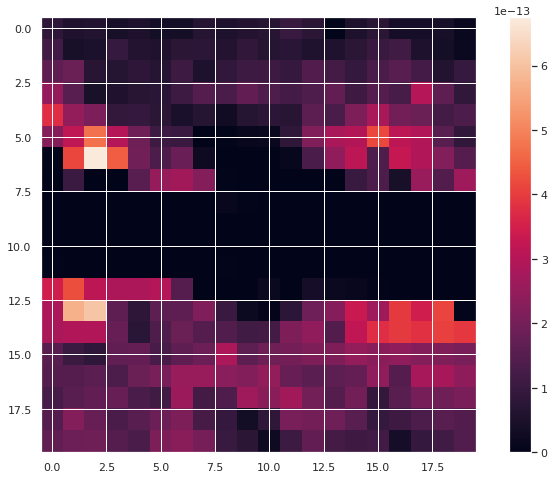

4.0981025e-08
4.098102630249158e-08


In [0]:
pre_path_alt = '/content/drive/My Drive/Colab Notebooks/master_project/Alternative_GDE/'

dust_pos =fits.getdata(pre_path_alt + 'DustPositive_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
dust_neg =fits.getdata(pre_path_alt + 'DustNegative_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]

dust_neg = np.array(dust_neg)
dust_pos = np.array(dust_pos)

H1_maps = []
H2_maps = []
for ring in range(1,5):
  map_H2 = fits.getdata(pre_path_alt + f'H2_pohl_ring_{ring}_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
  map_H1 = fits.getdata(pre_path_alt + f'HI_pohl_T150K_ring_{ring}_Normalized.fits')[(180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  H1_maps.append(map_H1)
  H2_maps.append(map_H2)

initial_norm_factor = (np.sum(H1_maps) + np.sum(H2_maps) + np.sum(dust_neg) + np.sum(dust_pos)) / np.sum(GCE_ring_maps) 
  
H1_maps_binned = []
H2_maps_binned = []

total_GCE = np.sum(GCE_ring_maps)
dust_pos_binned = []
dust_neg_binned = []

for e in range(len(energies)):
  sumo = 0
  for i in range(0,4):
    sumo += np.sum(GCE_ring_maps[i][e])
  frac = sumo / total_GCE
  dust_pos_binned.append(dust_pos * frac)
  dust_neg_binned.append(dust_neg * frac)


dust_pos_binned = np.array(dust_pos_binned) / initial_norm_factor
dust_neg_binned = np.array(dust_neg_binned) / initial_norm_factor

H1_maps_binned_tot = []
H2_maps_binned_tot = []
for ring in range(0,4):
  H1_maps_binned = []
  H2_maps_binned = []
  total = np.sum(GCE_ring_maps[ring])
  for e in range(len(energies)):
    sumi = np.sum(GCE_ring_maps[ring][e])
    frac = sumi / total
    H1_maps_binned.append(np.array(H1_maps[ring]*frac))
    H2_maps_binned.append(np.array(H2_maps[ring]*frac))
  H1_maps_binned_tot.append(H1_maps_binned)
  H2_maps_binned_tot.append(H2_maps_binned)

H1_maps_binned_tot = np.array(H1_maps_binned_tot) / initial_norm_factor
H2_maps_binned_tot = np.array(H2_maps_binned_tot) / initial_norm_factor

alternative_GDE = np.array([H1_maps_binned_tot,H2_maps_binned_tot,ics_ring_maps])
extras = np.array(dust_pos_binned + dust_neg_binned)

plt.figure(figsize=(12,8))
plt.imshow(dust_pos_binned[5])
plt.colorbar()
plt.show()


print (np.sum(GCE_ring_maps))
print (np.sum(H1_maps_binned_tot) + np.sum(H2_maps_binned_tot) + np.sum(dust_pos_binned) + np.sum(dust_neg_binned))

In [0]:
def mask_matrix_fu():

  catalog = fits.open(pre_path + 'gll_psch_v13.fit')

  ptsrc_long = []
  ptsrc_lat = []

  # Here is load all the point sources in our range of interest:
  for i in range(len(catalog[1].data)):
      if(catalog[1].data[i][9] > 4.0 and catalog[1].data[i][33] == ''):
          if(-roi + 180 <= catalog[1].data[i][3] <= roi + 180):
              if(-roi <= catalog[1].data[i][4] <= roi):
                  ptsrc_long.append(catalog[1].data[i][3])
                  ptsrc_lat.append(catalog[1].data[i][4])

  # Here I make a matrix that has a zero on all the positions that are +/- 0.25 degrees away from
  # a Fermi high energy source. Also the galactic ridge (+/- 0.3 degrees lattitude) are maskt.
  mask_matrix = []
  y_coor = 0
  x_min = 180 - roi
  x_max = 180 + roi
  y_min = - roi
  y_max = roi
  y_steps = 4 * roi
  x_steps = 4 * roi

  for y in np.linspace(y_max, y_min, y_steps):
      mask_matrix.append([])
      for x in np.linspace(x_min, x_max, x_steps):
          mark = 1
          for i in range(len(ptsrc_long)):
              ps_x = ptsrc_long[i]
              ps_y = ptsrc_lat[i]
              if abs(ps_x - x) < 0.25:
                  if abs(ps_y - y) < 0.25:
                      mark = 0
                      break
  #            if ((ps_x - x)**2 + (ps_y - y)**2)**0.5  < 0.25:
  #                mark = 0
          if abs(y) < 0.3:
              mark = 0
          mask_matrix[y_coor].append(mark)
      y_coor += 1

  mask_matrix = np.array(mask_matrix)
  return mask_matrix






In [0]:
class counts_maps:

  def __init__(self, GDE_maps, signal_map, extra_maps):

    "The Fermi_map"
    fermi_map = fits.getdata(pre_path + 'fig12_bubbles_template_3compSCA_40x40deg_inpaint.fits')
    norm = np.sum(fermi_map) * (np.pi/180.0)**2.0 * (0.5**2.0)
    fermi_map = fermi_map[(40 - 2*roi):(40 + 2 * roi),
                          (40 - 2*roi):(40 + 2 * roi)] / norm
                        
    self.fermi_map = fermi_map
    self.GDE_maps = GDE_maps
    self.signal_map = signal_map
    self.mask_matrix = mask_matrix_fu()
    self.extra_maps = extra_maps
                        
  
  def __fermi_function(self, E):
    phi0 = 1 * 10**-8
    sigma = 1.9
    E_co = 20

    fluxq = phi0 * np.exp(-E/E_co) * E ** -sigma * 5 **2 * (np.pi / 180) **2
    return fluxq

  def fermi_bubbles(self, i, j, E):
    fermi_bubble = self.__fermi_function(E)
    place_factor = self.fermi_map[i][j]

    return fermi_bubble * place_factor

  def signal_conv(self):
    signal_conv = np.zeros(shape = signal.shape)
    fermi_bubble_conv = np.zeros(shape = signal.shape)
    for k,i,j in np.ndindex(signal_conv.shape):
      if k < (len(energies)-1):
        E1 = energies[k]
        E2 = energies[k + 1]
        dE = E2 - E1
        fermi_bubble_conv[k][i][j] = self.fermi_bubbles(i, j, E1) * Eff_area(E1) * dE
        signal_conv[k][i][j] = self.signal_map[k][i][j] / TeV * Eff_area(E1) * dE * pre_normalisation

    return signal_conv * self.mask_matrix

  def fermi_bubbles_conv(self):
    fermi_bubble_conv = np.zeros(shape = signal.shape)
    for k,i,j in np.ndindex(fermi_bubble_conv.shape):
      if k < (len(energies)-1):
        E1 = energies[k]
        E2 = energies[k + 1]
        dE = E2 - E1
        fermi_bubble_conv[k][i][j] = self.fermi_bubbles(i, j, E1) * Eff_area(E1) * dE

    return fermi_bubble_conv * self.mask_matrix

  def convolving_GDE(self):

    GDE_conv= np.zeros(shape = self.GDE_maps.shape)

    for types,ring,k,i,j in np.ndindex(GDE_conv.shape):
      if k < (len(energies)-1):
        E1 = energies[k]
        E2 = energies[k + 1]
        dE = E2 - E1
        GDE_conv[types][ring][k][i][j] = self.GDE_maps[types][ring][k][i][j] / TeV * Eff_area(E1) * dE

    return GDE_conv * self.mask_matrix
  
  def extra_maps_conv(self):
    if len(self.extra_maps) == 0:
      return ("There are no extra maps")
    else:
      extras_conv= np.zeros(shape = self.extra_maps.shape)

      for types,k,i,j in np.ndindex(self.extra_maps.shape):
        if k < (len(energies)-1):
          E1 = energies[k]
          E2 = energies[k + 1]
          dE = E2 - E1
          extras_conv[types][k][i][j] =self.extra_maps[types][k][i][j] / TeV * Eff_area(E1) * dE
      return extras_conv



  def get_all_backgrounds(self):
    all_backgrounds = []
    GDE_maps = self.convolving_GDE()
    for types in GDE_maps:
      for rings in types:
        all_backgrounds.append(rings)
    if len(self.extra_maps) != 0:
      extras = self.extra_maps_conv()
      for maps in extras:
        all_backgrounds.append(maps)
    fermi_map = self.fermi_bubbles_conv()
    all_backgrounds.append(fermi_map)
    return np.array(all_backgrounds)


  
  def plot_maps(self):

    a = self.convolving_GDE()
    i,j,*e = a.shape
    energy_bin = 18
    Energie_plot = energies[energy_bin]
    fig, ax = plt.subplots(i+1,j, figsize = (15,11))
    for x in range(i):
      for y  in range(j):
        m1 = ax[x][y].imshow(a[x][y][20])
        plt.colorbar(m1, ax = ax[x][y])
    
    fermi_map = self.fermi_bubbles_conv()
    signal_map = self.signal_conv()
    m3 = ax[i][1].imshow(fermi_map[energy_bin], extent=[-5, 5, -5, 5])
    m4 = ax[i][2].imshow(signal_map[energy_bin], extent=[-5, 5, -5, 5])
    plt.colorbar(m3, ax = ax[2][1])
    plt.colorbar(m4, ax = ax[2][2])
    fig.delaxes(ax[i,0])
    fig.delaxes(ax[i,3])
    
    fig.suptitle("expected counts per bin  for E =" +
             str(round(Energie_plot, 2)) + ' TeV', fontsize=16)
    plt.show()


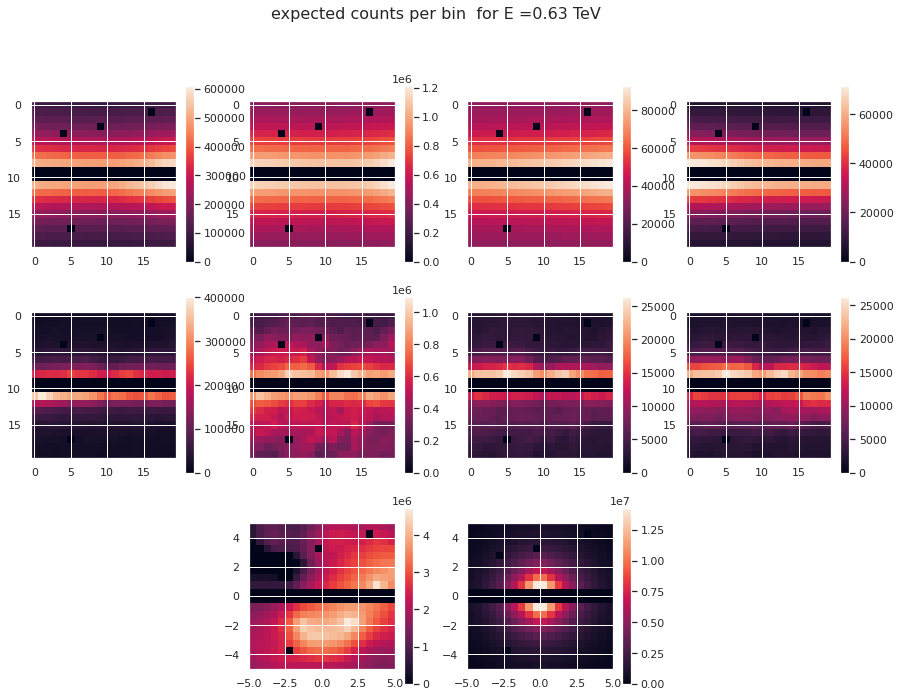

In [0]:
### Making the count maps
GDE_maps = np.array([ics_ring_maps, GCE_ring_maps])
alternative_GDE = np.array([ics_ring_maps, H1_maps_binned_tot,H2_maps_binned_tot])
extras = np.array([dust_pos_binned, dust_neg_binned])
MAPS_alternative = counts_maps(alternative_GDE, signal,extras)
MAPS_orig = counts_maps(GDE_maps, signal,[])
MAPS_orig.plot_maps()

In [0]:
simulated_backgrounds = MAPS_orig.get_all_backgrounds()
model_backgrounds = MAPS_alternative.get_all_backgrounds()
signal_c = MAPS_orig.signal_conv()
print (simulated_backgrounds.shape)
print (model_backgrounds.shape)


(9, 47, 20, 20)
(15, 47, 20, 20)


In [0]:
print (signal_c.shape)

(47, 20, 20)


In [0]:

files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
origianl_file = open(files_paths + 'Original_model_data.txt.txt', "w")
alternative_file = open(files_paths + 'alternative_model.txt', "w")
signal_file = open(files_paths + 'signal_data.txt', "w")

for i in np.ndindex(simulated_backgrounds.shape):
  np.savetxt(origianl_file, [simulated_backgrounds[i]])

for i in np.ndindex(model_backgrounds.shape):
  np.savetxt(alternative_file, [model_backgrounds[i]])
for i in np.ndindex(signal_c.shape):
  np.savetxt(signal_file, [signal_c[i]])

origianl_file.close()
alternative_file.close()
signal_file.close()


In [0]:
a_file.close()